<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [1]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
from datetime import datetime, date, time, timezone, timedelta 
import os
import re 

from functools import reduce
from collections import defaultdict, Counter, ChainMap

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'online_retail_II.xlsx',
 'scanner_data.csv',
 'test.csv',
 'sample_data']

In [3]:
df = pd.read_csv('scanner_data.csv')
df.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [4]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.columns = [a.lower() if a != 'Customer_ID' else 'id' for a in df.columns]
df.head()

,date,id,transaction_id,sku_category,sku,quantity,sales_amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].to_numpy().astype('datetime64[M]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['rev'] = df.quantity * df.sales_amount 
df.head()

,date,id,transaction_id,sku_category,sku,quantity,sales_amount,month,week,rev
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,2016-02-01,2016-02-01,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,2016-02-01,2016-02-01,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,2016-02-01,2016-02-01,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,2016-02-01,2016-02-01,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,2016-02-01,2016-02-01,6.88


In [6]:
df = df.groupby(['id','date','week','month', 'sku_category'])['rev'].sum().reset_index()
df.head()

,id,date,week,month,sku_category,rev
0,1,2016-01-22,2016-01-18,2016-01-01,0H2,10.50
1,1,2016-01-22,2016-01-18,2016-01-01,N8U,5.79
2,2,2016-03-24,2016-03-21,2016-03-01,TVL,7.77
3,2,2016-06-19,2016-06-13,2016-06-01,F9B,15.00
4,3,2016-02-01,2016-02-01,2016-02-01,LPF,16.32


In [17]:
list_npu = df.groupby(['id'])['date'].min().reset_index().rename(columns = {'date':'npu_date'})
df_ = pd.merge(df, list_npu, 'left', 'id')
df_['days'] = (df_['date'] - df_['npu_date']).dt.days
df_.head() 

,id,date,week,month,sku_category,rev,npu_date,days
0,1,2016-01-22,2016-01-18,2016-01-01,0H2,10.50,2016-01-22,0
1,1,2016-01-22,2016-01-18,2016-01-01,N8U,5.79,2016-01-22,0
2,2,2016-03-24,2016-03-21,2016-03-01,TVL,7.77,2016-03-24,0
3,2,2016-06-19,2016-06-13,2016-06-01,F9B,15.00,2016-03-24,87
4,3,2016-02-01,2016-02-01,2016-02-01,LPF,16.32,2016-02-01,0


In [16]:
chk = df.groupby(['sku_category'])['id'].count().reset_index().rename(columns = {'id':'cnt'})
chk['ratio'] = round(chk['cnt']/chk['cnt'].sum() * 100, 2)
chk.sort_values(['ratio'], ascending = 0, inplace = True)
chk = chk[chk['ratio'] >= 2]
chk

,sku_category,cnt,ratio
119,N8U,9864,8.15
106,LPF,4621,3.82
148,R6E,4579,3.79
133,P42,4444,3.67
2,0H2,4147,3.43
91,IEV,4106,3.39
164,U5F,3590,2.97
69,FEW,2929,2.42
13,29A,2872,2.37
79,H15,2757,2.28


In [19]:
cnt = df_[df_['sku_category'].isin(chk['sku_category'])].groupby(['sku_category', 'days'])['id'].count().reset_index().rename(columns = {'id':'pu'})
cnt['ratio'] = cnt.groupby(['sku_category'])['pu'].apply(lambda x : round(x/x.max()*100,2))
cnt = pd.melt(cnt, id_vars = ['sku_category','days'], var_name = 'type')
cnt.head()

,sku_category,days,type,value
0,0H2,0,pu,1623.0
1,0H2,1,pu,23.0
2,0H2,2,pu,9.0
3,0H2,3,pu,17.0
4,0H2,4,pu,16.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


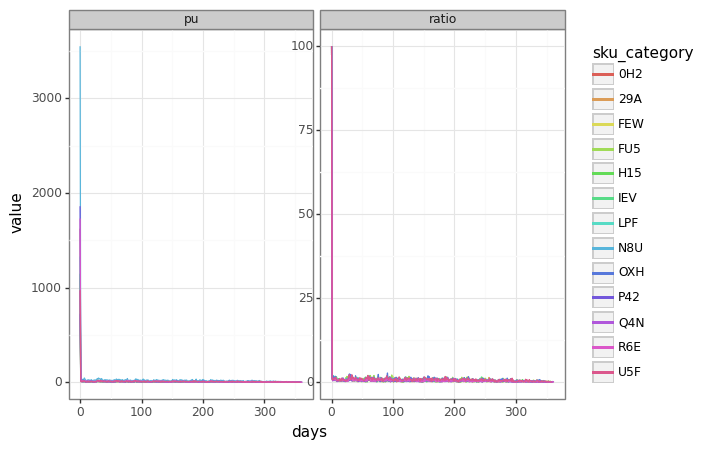

<ggplot: (8788881826237)>

In [21]:
(
    ggplot(cnt, aes('days','value', color = 'sku_category')) +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# Iterator

In [22]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a = { letters : [r, c] for r, rows in enumerate(mat) for c, letters in enumerate(rows)}
a

{'A': [0, 0],
 'B': [0, 1],
 'C': [0, 2],
 'D': [1, 0],
 'E': [1, 1],
 'F': [1, 2],
 'G': [2, 0],
 'H': [2, 1],
 'I': [2, 2]}

In [23]:
arr = np.empty([3,3], dtype = 'object')
for k, v in a.items() :
  arr[v[0], v[1]] = k
arr

array([['A', 'B', 'C'],
       ['D', 'E', 'F'],
       ['G', 'H', 'I']], dtype=object)

In [25]:
def add_arthor_with_name(name) :
  def add_arthor(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper
  return add_arthor

def calc_time(func) :
  def wrapper(*args, **kwargs) :
    a = datetime.now()
    func(*args, **kwargs)
    b = datetime.now()
    return func(*args, **kwargs)
  return wrapper

@calc_time
@add_arthor_with_name('park')
def get_title(name) :
  return name

In [27]:
print(get_title('아무 일도 없었던 걸로'))

park
아무 일도 없었던 걸로
